In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [154]:
df = pd.read_parquet("outputs/esri_with_polluted_heatday_coldday_hotspot.parquet")

In [155]:
df = df.drop(columns=["tmax","tmin","pm25"])

In [156]:
df.head()

wfday  heatday  coldday  polluted  hotspot
time       FIPS                                              
2005-12-31 1765.0  False    False    False     False    False
           1766.0  False    False    False     False    False
           1767.0  False    False    False     False    False
           1768.0  False    False    False     False    False
           1769.0  False    False    False     False    False

## Get time lag

In [83]:
def get_eves_time_lag(eve1, eve2):
    # get data subset with events
    hdf = df[df[eve1] | df[eve2]]
    hdf = hdf[[eve1, eve2]].reset_index()

    # find cocurence point
    hdf["cco1"] = np.where(
        hdf[eve1] & hdf[eve2], 
        False, # cut period with the cocurence point
        hdf[eve1]
    )

    # find cocurence point
    hdf["cco2"] = np.where(
        hdf[eve1] & hdf[eve2], 
        False, # cut period with the cocurence point
        hdf[eve2]
    )

    grouped_hdf = hdf.sort_values(['time']).groupby(["FIPS"])

    # remove sequences in event 1
    hdf['shift_plus'] = grouped_hdf['cco1'].shift(fill_value = False)
    hdf['shift_minus'] = grouped_hdf['cco1'].shift(-1, fill_value = False)
    # gets first and last day in a sequence of days
    hdf['mask'] = ~hdf[['cco1','shift_plus','shift_minus']].min(axis=1)

    # remove sequences in event 2
    hdf['shift_plus'] = grouped_hdf['cco2'].shift(fill_value = False)
    hdf['shift_minus'] = grouped_hdf['cco2'].shift(-1, fill_value = False)
    # gets first and last day in a sequence of days
    hdf['mask2'] = ~hdf[['cco2','shift_plus','shift_minus']].min(axis=1)

    hdf = hdf[hdf["mask"]]
    hdf = hdf[hdf["mask2"]]

    hdf = hdf.drop(
        columns=['cco1','cco2','shift_plus','shift_minus','mask','mask2'])

    # time lag == 0
    res = hdf[hdf[eve1] & hdf[eve2]].copy()
    res['difference'] = 0

    # remove eves with time lag == 0
    hdf.drop(hdf[hdf[eve1] & hdf[eve2]].index, inplace=True)


    # difference between consequentive events per location
    hdf['difference'] = hdf.sort_values(
        ['time']).groupby('FIPS')['time'].diff()

    # get only events where eve1 is first and eve2 is second
    hdf[eve1+'_shift'] = hdf.groupby('FIPS')[eve1].shift()
    hdf = hdf[hdf[eve2] & hdf[eve1+'_shift']]

    hdf["difference"] = hdf["difference"].dt.days
    hdf = hdf.drop(columns= eve1+'_shift')

    res = pd.concat([hdf,res])
    return res

In [119]:
time_lag_dict = {}

for eve1 in ["wfday", "polluted", "heatday"]:
    for eve2 in ["wfday", "polluted", "heatday"]:
        if eve1 != eve2:
            temp = get_eves_time_lag(eve1, eve2)
            temp = temp[temp.difference < 15]
            
            a = eve1
            b = eve2
            if eve1 == "wfday":
                a = "wildfire"
            if eve2 == "wfday":
                b = "wildfire"
            if eve1 == "polluted":
                a = "pollution"
            if eve2 == "polluted":
                b = "pollution"
            name = a+" to "+b
            time_lag_dict[name] = temp

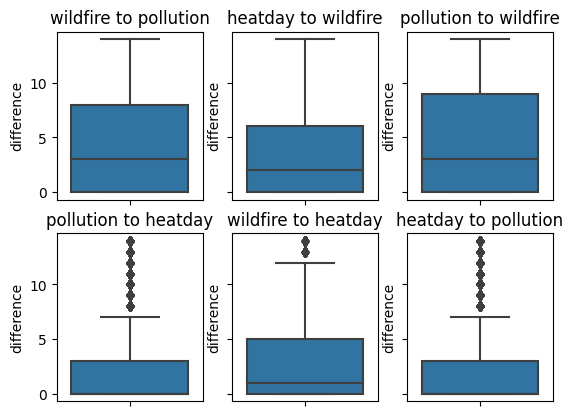

In [147]:
fig, axes = plt.subplots(2, 3, sharey=True)

for i, lab in zip(range(6), time_lag_dict.keys()):
    sns.boxplot(data=time_lag_dict[lab], y ="difference", ax=axes[i%2, i%3]).set(title=lab)

In [152]:
for i, lab in zip(range(6), time_lag_dict.keys()):
    print(lab + ": " + str(time_lag_dict[lab].difference.mean().round(2))+" days. Sample: "+
         str(len(time_lag_dict[lab])))

wildfire to pollution: 4.3 days. Sample: 1155
wildfire to heatday: 3.1 days. Sample: 7363
pollution to wildfire: 4.48 days. Sample: 1062
pollution to heatday: 2.08 days. Sample: 105319
heatday to wildfire: 3.33 days. Sample: 7657
heatday to pollution: 1.95 days. Sample: 115406


In [170]:
df = df.reset_index()

In [194]:
dfres = df.groupby("FIPS").resample('6M', on="time").sum()

In [172]:
dfres["total"] = dfres[["wfday","heatday","polluted"]].sum(axis=1)

In [197]:
dfres = dfres.drop(columns="FIPS")

In [176]:
temp = dfres.reset_index().groupby("FIPS")["total"].sum()

In [184]:
l = temp.sort_values().tail(5).index

In [198]:
dfres = dfres.reset_index()

In [199]:
dfres[dfres.FIPS.isin(l)].head()

,FIPS,time,index,wfday,heatday,coldday,polluted,hotspot
23727,2496.0,2005-12-31,719,0,0,0,0,0
23728,2496.0,2006-06-30,148220900,0,11,21,24,0
23729,2496.0,2006-12-31,452595380,0,24,23,30,0
23730,2496.0,2007-06-30,742211315,0,3,28,30,0
23731,2496.0,2007-12-31,1056430940,0,22,24,41,0


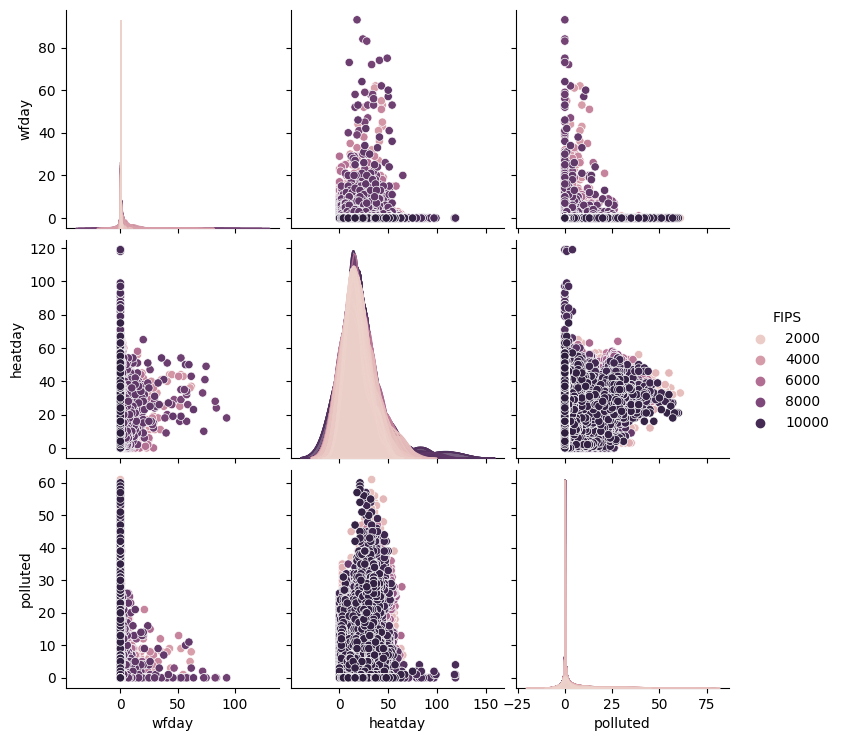

In [201]:
sns.pairplot(dfres[["FIPS","wfday","heatday","polluted"]], hue="FIPS")